(a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/
Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\
%29 . The dataset contains 7 folders that represent seven types of activities. In
each folder, there are multiple les each of which represents an instant of a human
performing an activity.1 Each le containis 6 time series collected from activities
of the same person, which are called avg rss12, var rss12, avg rss13, var rss13,
vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains
6 time series and each time series has 480 consecutive values.

dataset 4 in bending2 folder had values clubbed in first column only because of the space. opened it in vs code, repalced space by comma and made it right.

Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,
2, and 3 in other folders as test data and other datasets as train data.

organised folders as above in the AReM_modified folder


(c) Feature Extraction
Classification of time series usually needs extracting features from them. In this
problem, we focus on time-domain features.
i. Research what types of time-domain features are usually used in time series
classification and list them (examples are minimum, maximum, mean, etc).

Answer: Here are commonly used time-domain features - 
Mean
Standard Deviation, Variance, Minimum Value, Maximum Value, Range, Median, Quartiles, Interquartile Range (IQR)
Skewness: A measure of the asymmetry of the distribution of values.

Kurtosis: A measure of the "tailedness" or the sharpness of the peak of the distribution.

Root Mean Square (RMS): The square root of the average of the squared values.

Energy: The sum of the squared values, representing the total power of the time series.

Entropy: A measure of the randomness or disorder.

Zero-Crossing Rate: The rate at which the time series values cross the zero axis.

Mean Absolute Deviation (MAD): The average of the absolute deviations from the mean.

Autocorrelation: The correlation of the time series with a lagged version of itself.

Peak-to-Peak Amplitude: The difference between the highest and lowest points.

Signal Magnitude Area (SMA): The sum of the absolute values, often used in accelerometer data analysis.

Harmonic Mean: The reciprocal of the average of the reciprocals of the values.


references : https://tsfel.readthedocs.io/en/latest/descriptions/feature_list.html

https://jwcn-eurasipjournals.springeropen.com/articles/10.1186/s13638-020-1661-4#Sec1

https://stats.stackexchange.com/questions/50807/features-for-time-series-classification#:~:text=Usually%20the%20features%20used%20to,than%20being%20features%20in%20themselves.

ii. Extract the time-domain features minimum, maximum, mean, median, standard
deviation, First quartile, and third quartile for all of the 6 time series
in each instance. You are free to normalize/standardize features or use them
directly.2 (20 pts)

In [43]:
import os
path = os.getcwd()
print(path)

f:\AssignmentsUSC\Homework4\homework-4-niveditha-7


In [45]:
path = path+'/AReM_modified'
print(path)

f:\AssignmentsUSC\Homework4\homework-4-niveditha-7/AReM_modified


In [3]:

import pandas as pd


  
activity_folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking'] 

feature_names = ['min', 'max', 'mean', 'median', 'std', '1st_quart', '3rd_quart']
time_series_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']


def extract_features(file_path):
    try:
       
        df = pd.read_csv(file_path, skiprows=4)
        
        if df.empty:
            return None
        
       
        feature_dict = {}
        
        for column in time_series_columns:
            if column in df.columns:
                feature_dict[f'min_{column}'] = df[column].min()
                feature_dict[f'max_{column}'] = df[column].max()
                feature_dict[f'mean_{column}'] = df[column].mean()
                feature_dict[f'median_{column}'] = df[column].median()
                feature_dict[f'std_{column}'] = df[column].std()
                feature_dict[f'1st_quart_{column}'] = df[column].quantile(0.25)
                feature_dict[f'3rd_quart_{column}'] = df[column].quantile(0.75)
            else:
                print(f"Column {column} not found in file: {file_path}")
                return None
        
        return feature_dict
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None
def process_directory(base_dir, subfolder, activity_folders):
    feature_list = []
    instance_counter = 1
    for folder in activity_folders:
        folder_path = os.path.join(base_dir, folder, subfolder)
        if not os.path.exists(folder_path):
            print(f"Path does not exist: {folder_path}")
            continue
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                features = extract_features(file_path)
                if features is not None:
                    features['Instance'] = instance_counter
                    features['Activity'] = folder
                    feature_list.append(features)
                    instance_counter += 1
                else:
                    print(f"Failed to extract features for file: {file_path}")
    if feature_list:
        return pd.DataFrame(feature_list)
    else:
        print(f"No valid feature data found in {subfolder}")
        return pd.DataFrame()


train_features_df = process_directory(path, 'trainData', activity_folders)

test_features_df = process_directory(path, 'testData', activity_folders)


all_features_df = pd.concat([train_features_df, test_features_df], ignore_index=True)


if all_features_df.empty:
    print("Combined features DataFrame is empty.")
else:
    all_features_df.to_csv(os.path.join(path, 'all_features.csv'), index=False)
    print("All features saved to CSV.")

print("Feature extraction for train and test data complete.")


All features saved to CSV.
Feature extraction for train and test data complete.


iii. Estimate the standard deviation of each of the time-domain features you
extracted from the data. Then, use Python's bootstrapped or any other
method to build a 90% bootsrap confidence interval for the standard deviation
of each feature. (10)

ref- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
import os


path = 'F:\\AssignmentsUSC\\Homework4\\homework-4-niveditha-7\\AReM_modified'
all_features_path = os.path.join(path, 'all_features.csv')
all_features_df = pd.read_csv(all_features_path)

# Function to calculate standard deviation using scipy's bootstrap
def bootstrap_std_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.90):
    data = np.array(data)
    
    
    res = bootstrap((data,), np.std, method='percentile', confidence_level=confidence_level)
    
    lower_bound, upper_bound = res.confidence_interval
    return lower_bound, upper_bound

# Exclude non-feature columns
feature_columns = [col for col in all_features_df.columns if col not in ['Instance', 'Activity']]

# Dictionary to store bootstrap results
bootstrap_results = {}

# Calculate standard deviation and bootstrap confidence intervals for each feature
for feature in feature_columns:
    data = all_features_df[feature].dropna()
    std_dev = np.std(data)
    
    lower_bound, upper_bound = bootstrap_std_confidence_interval(data)
    ci_width = upper_bound - lower_bound
    
    bootstrap_results[feature] = {
        'std_dev': std_dev,
        '90% CI lower bound': lower_bound,
        '90% CI upper bound': upper_bound,
        'CI width': ci_width
    }


bootstrap_results_df = pd.DataFrame(bootstrap_results).T
print(bootstrap_results_df)

bootstrap_results_path = os.path.join(path, 'bootstrap_std_dev_ci.csv')



                       std_dev  90% CI lower bound  90% CI upper bound  \
min_avg_rss12        10.000011            8.564825           11.272646   
max_avg_rss12         6.298129            3.437648            9.028858   
mean_avg_rss12        6.640042            4.809349            8.661718   
median_avg_rss12      6.738517            4.898443            8.783694   
std_avg_rss12         1.774857            1.574183            1.951735   
1st_quart_avg_rss12   7.222906            5.696428            8.988019   
3rd_quart_avg_rss12   6.594380            4.428738            8.864628   
min_var_rss12         0.000000            0.000000            0.000000   
max_var_rss12         5.075860            4.651624            5.404676   
mean_var_rss12        1.713627            1.454521            1.961053   
median_var_rss12      1.604918            1.296952            1.927549   
std_var_rss12         0.912185            0.824459            0.983963   
1st_quart_var_rss12   1.064020        

iv Use your judgement to select the three most important time-domain features
(one option may be min, mean, and max).

When we calculate the confidence intervals for the standard deviation (or other statistical measures) of each feature, those with narrower confidence intervals generally provide more reliable information about the variability in the data. Features with high variability or wide confidence intervals may contribute less to a stable model. 

ref- https://rangelandsgateway.org/inventorymonitoring/confidence#:~:text=A%20large%20confidence%20interval%20suggests,a%20greater%20degree%20of%20precision.

In [33]:

sorted_features_df = bootstrap_results_df.sort_values(by='CI width')
print(sorted_features_df)
sorted_features_df.to_csv(bootstrap_results_path, index=True)

                       std_dev  90% CI lower bound  90% CI upper bound  \
min_var_rss12         0.000000            0.000000            0.000000   
std_var_rss13         0.458964            0.423145            0.486796   
std_var_rss23         0.513989            0.476340            0.541661   
min_var_rss23         0.045835            0.000000            0.078460   
1st_quart_var_rss23   0.757152            0.689757            0.805669   
mean_var_rss23        1.150552            1.059932            1.208392   
median_var_rss23      1.083576            0.990702            1.143418   
std_var_rss12         0.912185            0.824459            0.983963   
3rd_quart_var_rss23   1.518071            1.396567            1.594870   
min_avg_rss13         2.939616            2.738439            3.092893   
std_avg_rss12         1.774857            1.574183            1.951735   
std_avg_rss13         0.991231            0.794909            1.174419   
1st_quart_var_rss12   1.064020        

In [34]:

top_features = sorted_features_df.head(3).index.tolist()
print(f"Top 3 important features based on confidence intervals: {top_features}")


Top 3 important features based on confidence intervals: ['min_var_rss12', 'std_var_rss13', 'std_var_rss23']


but having more diverse features might give more information. In this case, I would include min_var_rss12, std_var_rss13, and the next feature with a different measure, mean_var_rss23.

v. Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 7(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See
p. 129 of the ISLR textbook).3(10 pts)

In [16]:
import pandas as pd
all_features_path = 'F:\\AssignmentsUSC\\Homework4\\homework-4-niveditha-7\\AReM_modified\\all_features.csv'
all_features_df = pd.read_csv(all_features_path)

testing_start_row = 69
test_features_df = all_features_df.iloc[testing_start_row:]

train_features_df = all_features_df.iloc[:testing_start_row]
print(train_features_df.head())
print(train_features_df.tail())

   min_avg_rss12  max_avg_rss12  mean_avg_rss12  median_avg_rss12  \
0          35.00          47.40       43.954500             44.33   
1          33.00          47.75       42.179812             43.50   
2          33.00          45.75       41.678063             41.75   
3          37.00          48.00       43.454958             43.25   
4          36.25          48.00       43.969125             44.50   

   std_avg_rss12  1st_quart_avg_rss12  3rd_quart_avg_rss12  min_var_rss12  \
0       1.558835                43.00                45.00            0.0   
1       3.670666                39.15                45.00            0.0   
2       2.243490                41.33                42.75            0.0   
3       1.386098                42.50                45.00            0.0   
4       1.618364                43.31                44.67            0.0   

   max_var_rss12  mean_var_rss12  ...  3rd_quart_avg_rss23  min_var_rss23  \
0           1.70        0.426250  ...        

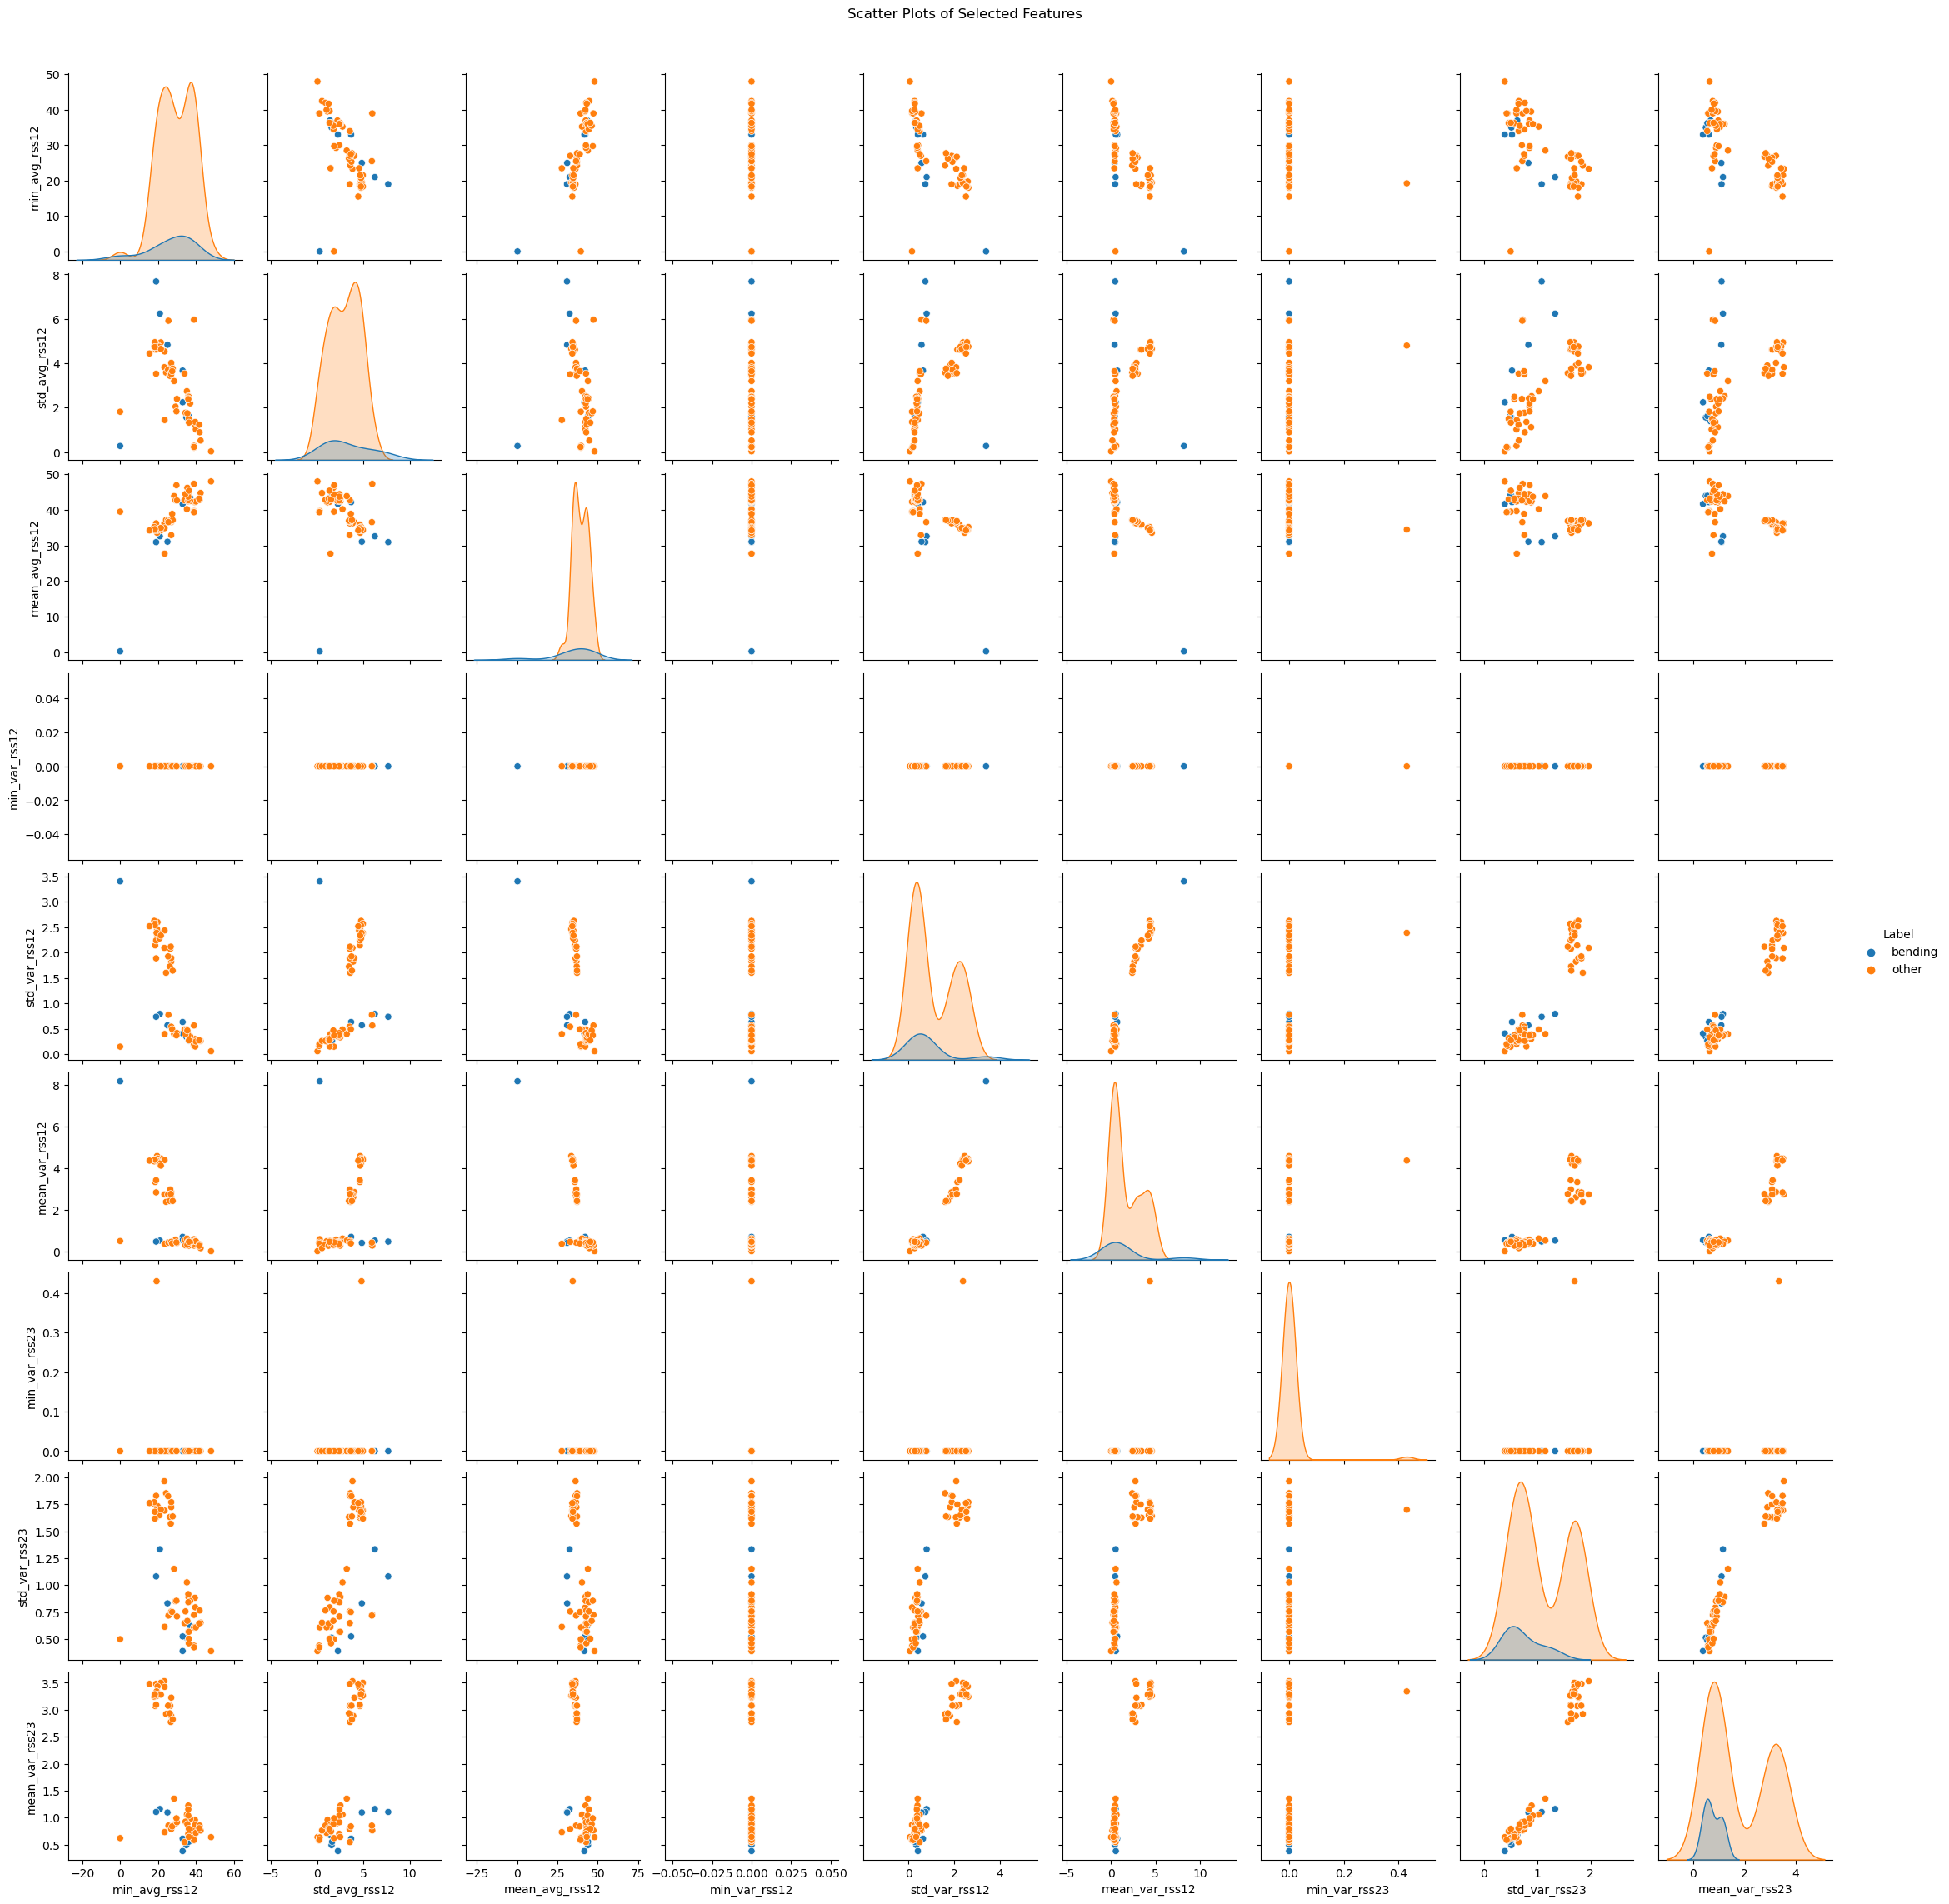

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


series_names = ['avg_rss12', 'var_rss12', 'var_rss23']  # Corresponding to time series 1, 2, 6
features_formatname = ['min', 'std', 'mean']
col_class = [f"{feature}_{series}" for series in series_names for feature in features_formatname]
col_class.append("Activity")
filtered_df = train_features_df[col_class].copy()

filtered_df['Label'] = filtered_df['Activity'].apply(lambda x: 'bending' if 'bending' in x else 'other')#refered to chatgpt for lambda

sns.pairplot(filtered_df, hue='Label', vars=col_class[:-1])  # Exclude 'Activity' from vars
plt.suptitle('Scatter Plots of Selected Features - min, std, mean', y=1.02)
plt.show()


for mean, median std and time series - 1,2,6


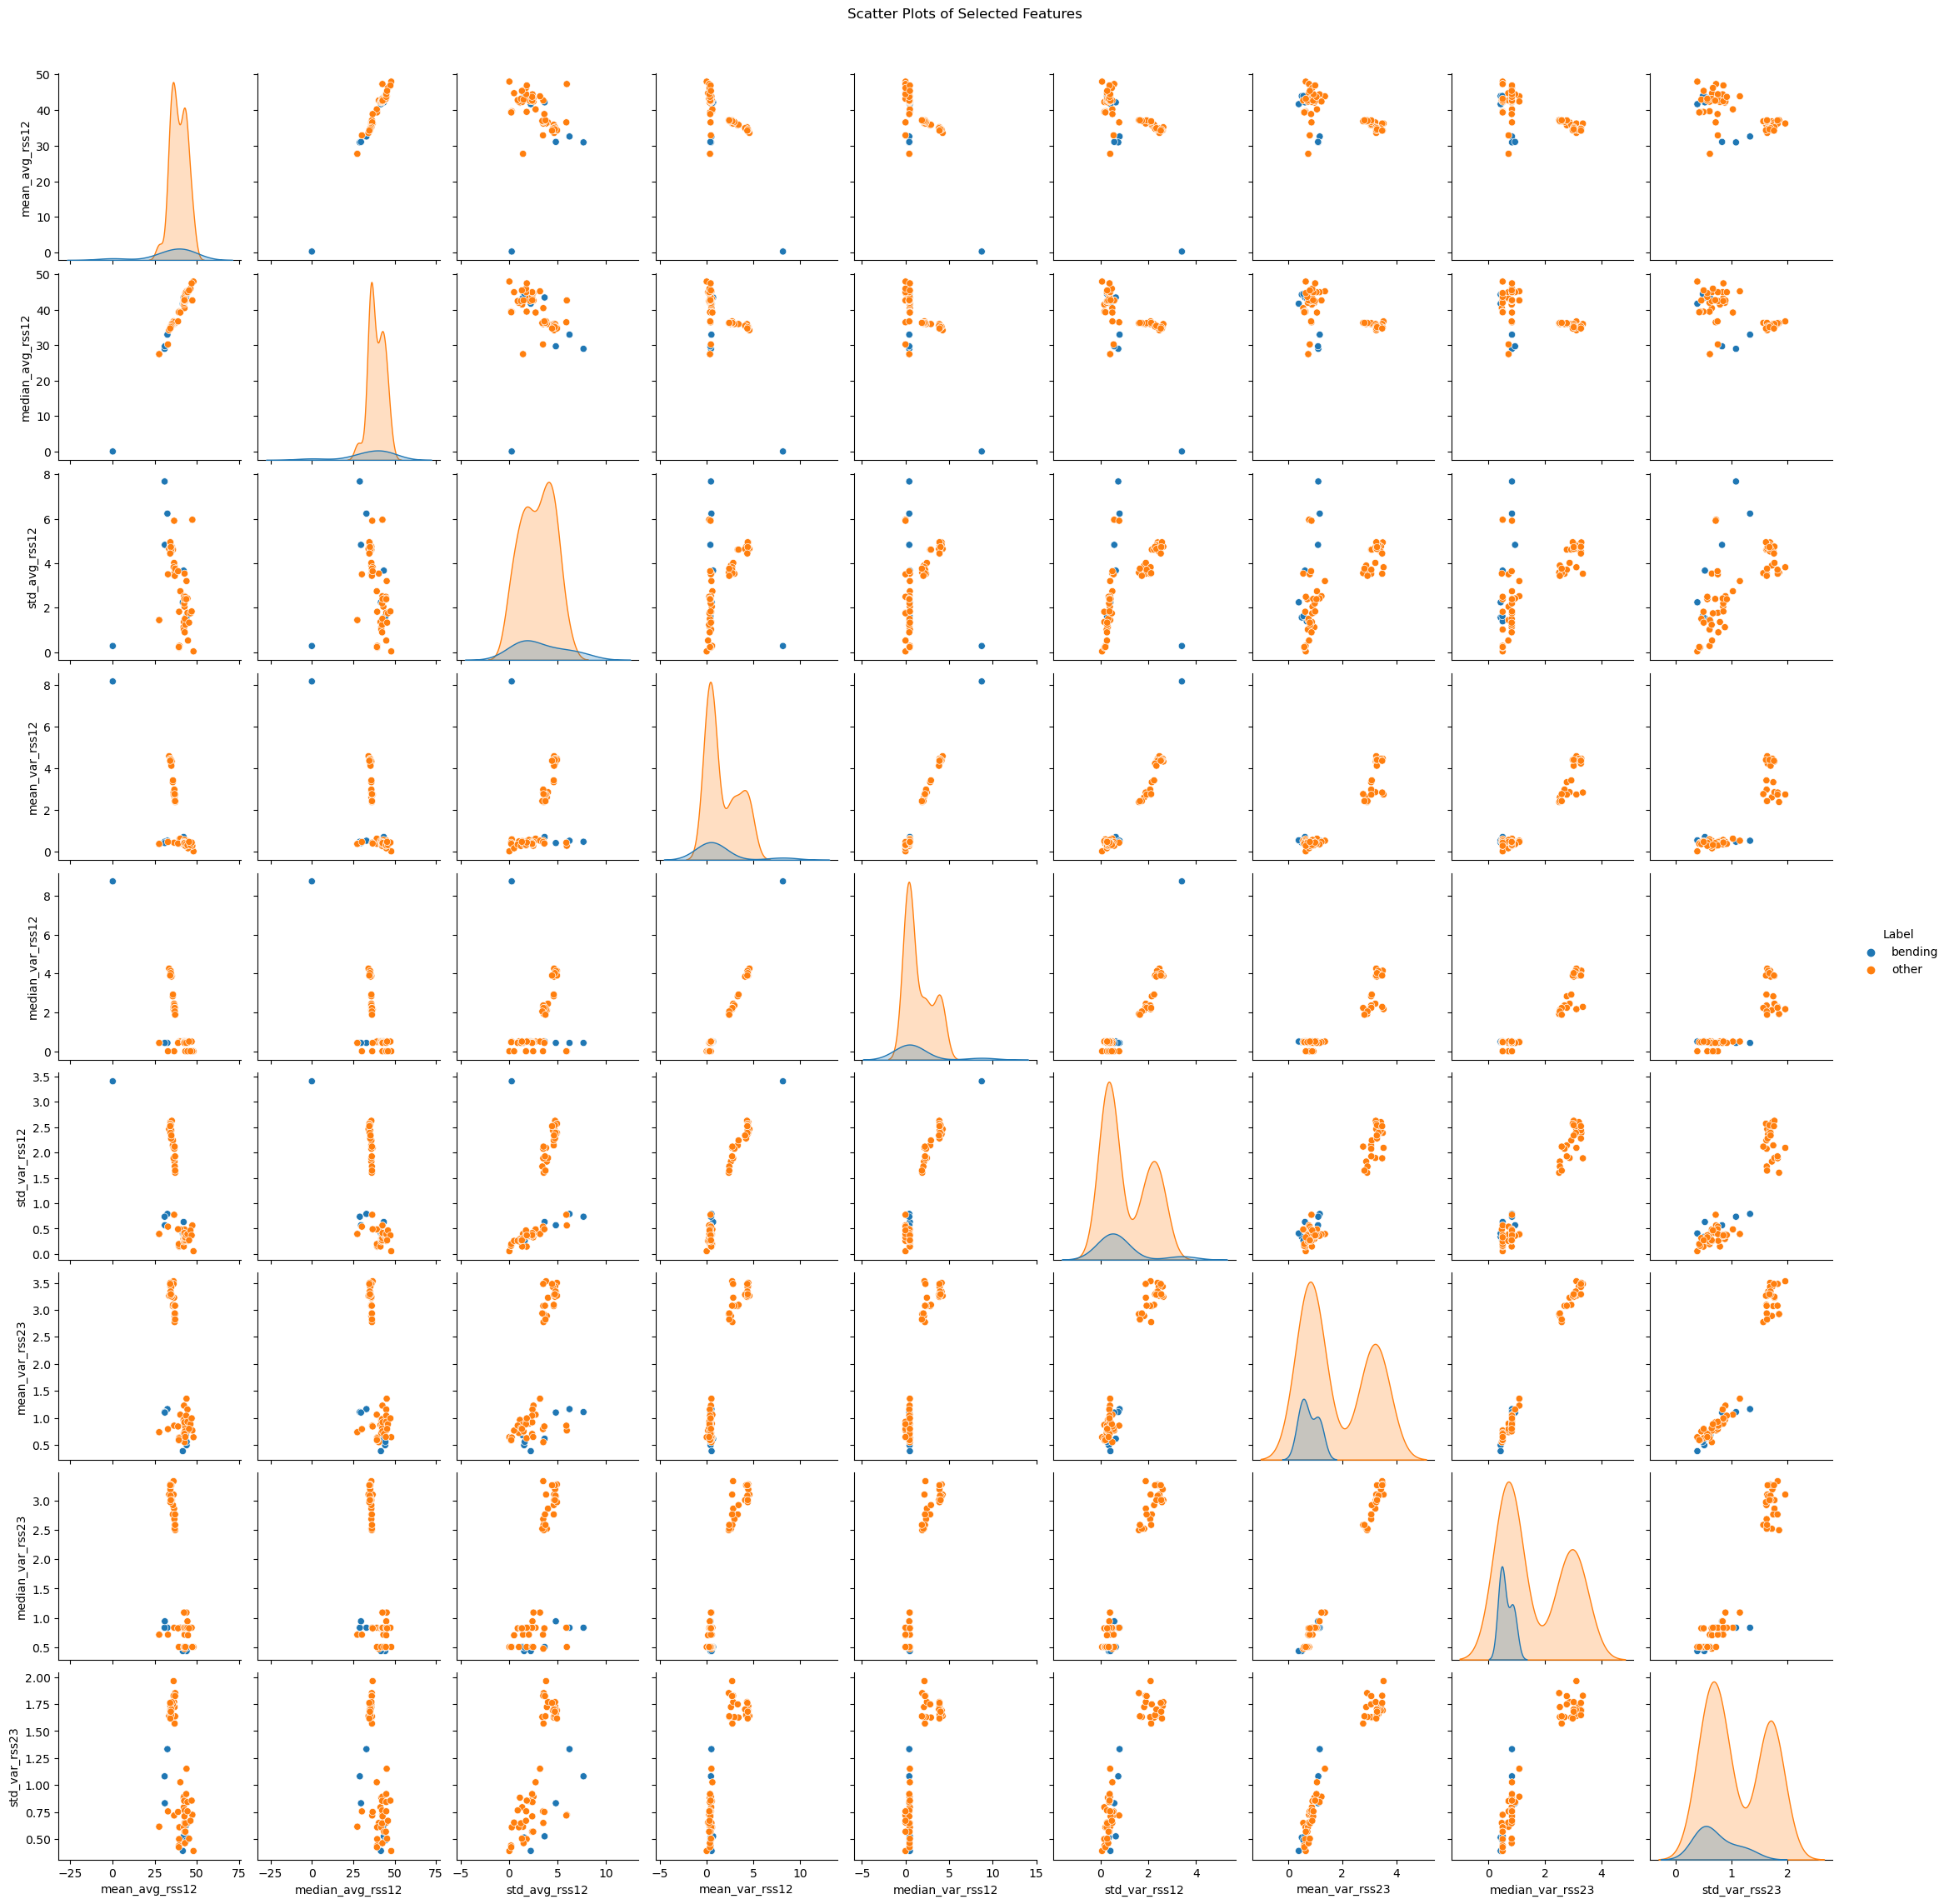

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


series_names = ['avg_rss12', 'var_rss12', 'var_rss23']  # Corresponding to time series 1, 2, 6
features_formatname = ['mean', 'median', 'std']
col_class = [f"{feature}_{series}" for series in series_names for feature in features_formatname]
col_class.append("Activity")
filtered_df = train_features_df[col_class].copy()

filtered_df['Label'] = filtered_df['Activity'].apply(lambda x: 'bending' if 'bending' in x else 'other')#refered to chatgpt for lambda

sns.pairplot(filtered_df, hue='Label', vars=col_class[:-1])  # Exclude 'Activity' from vars
plt.suptitle('Scatter Plots of Selected Features- mean, median and std', y=1.02)
plt.show()


for features - mean,median, std and time series - 3,4,5

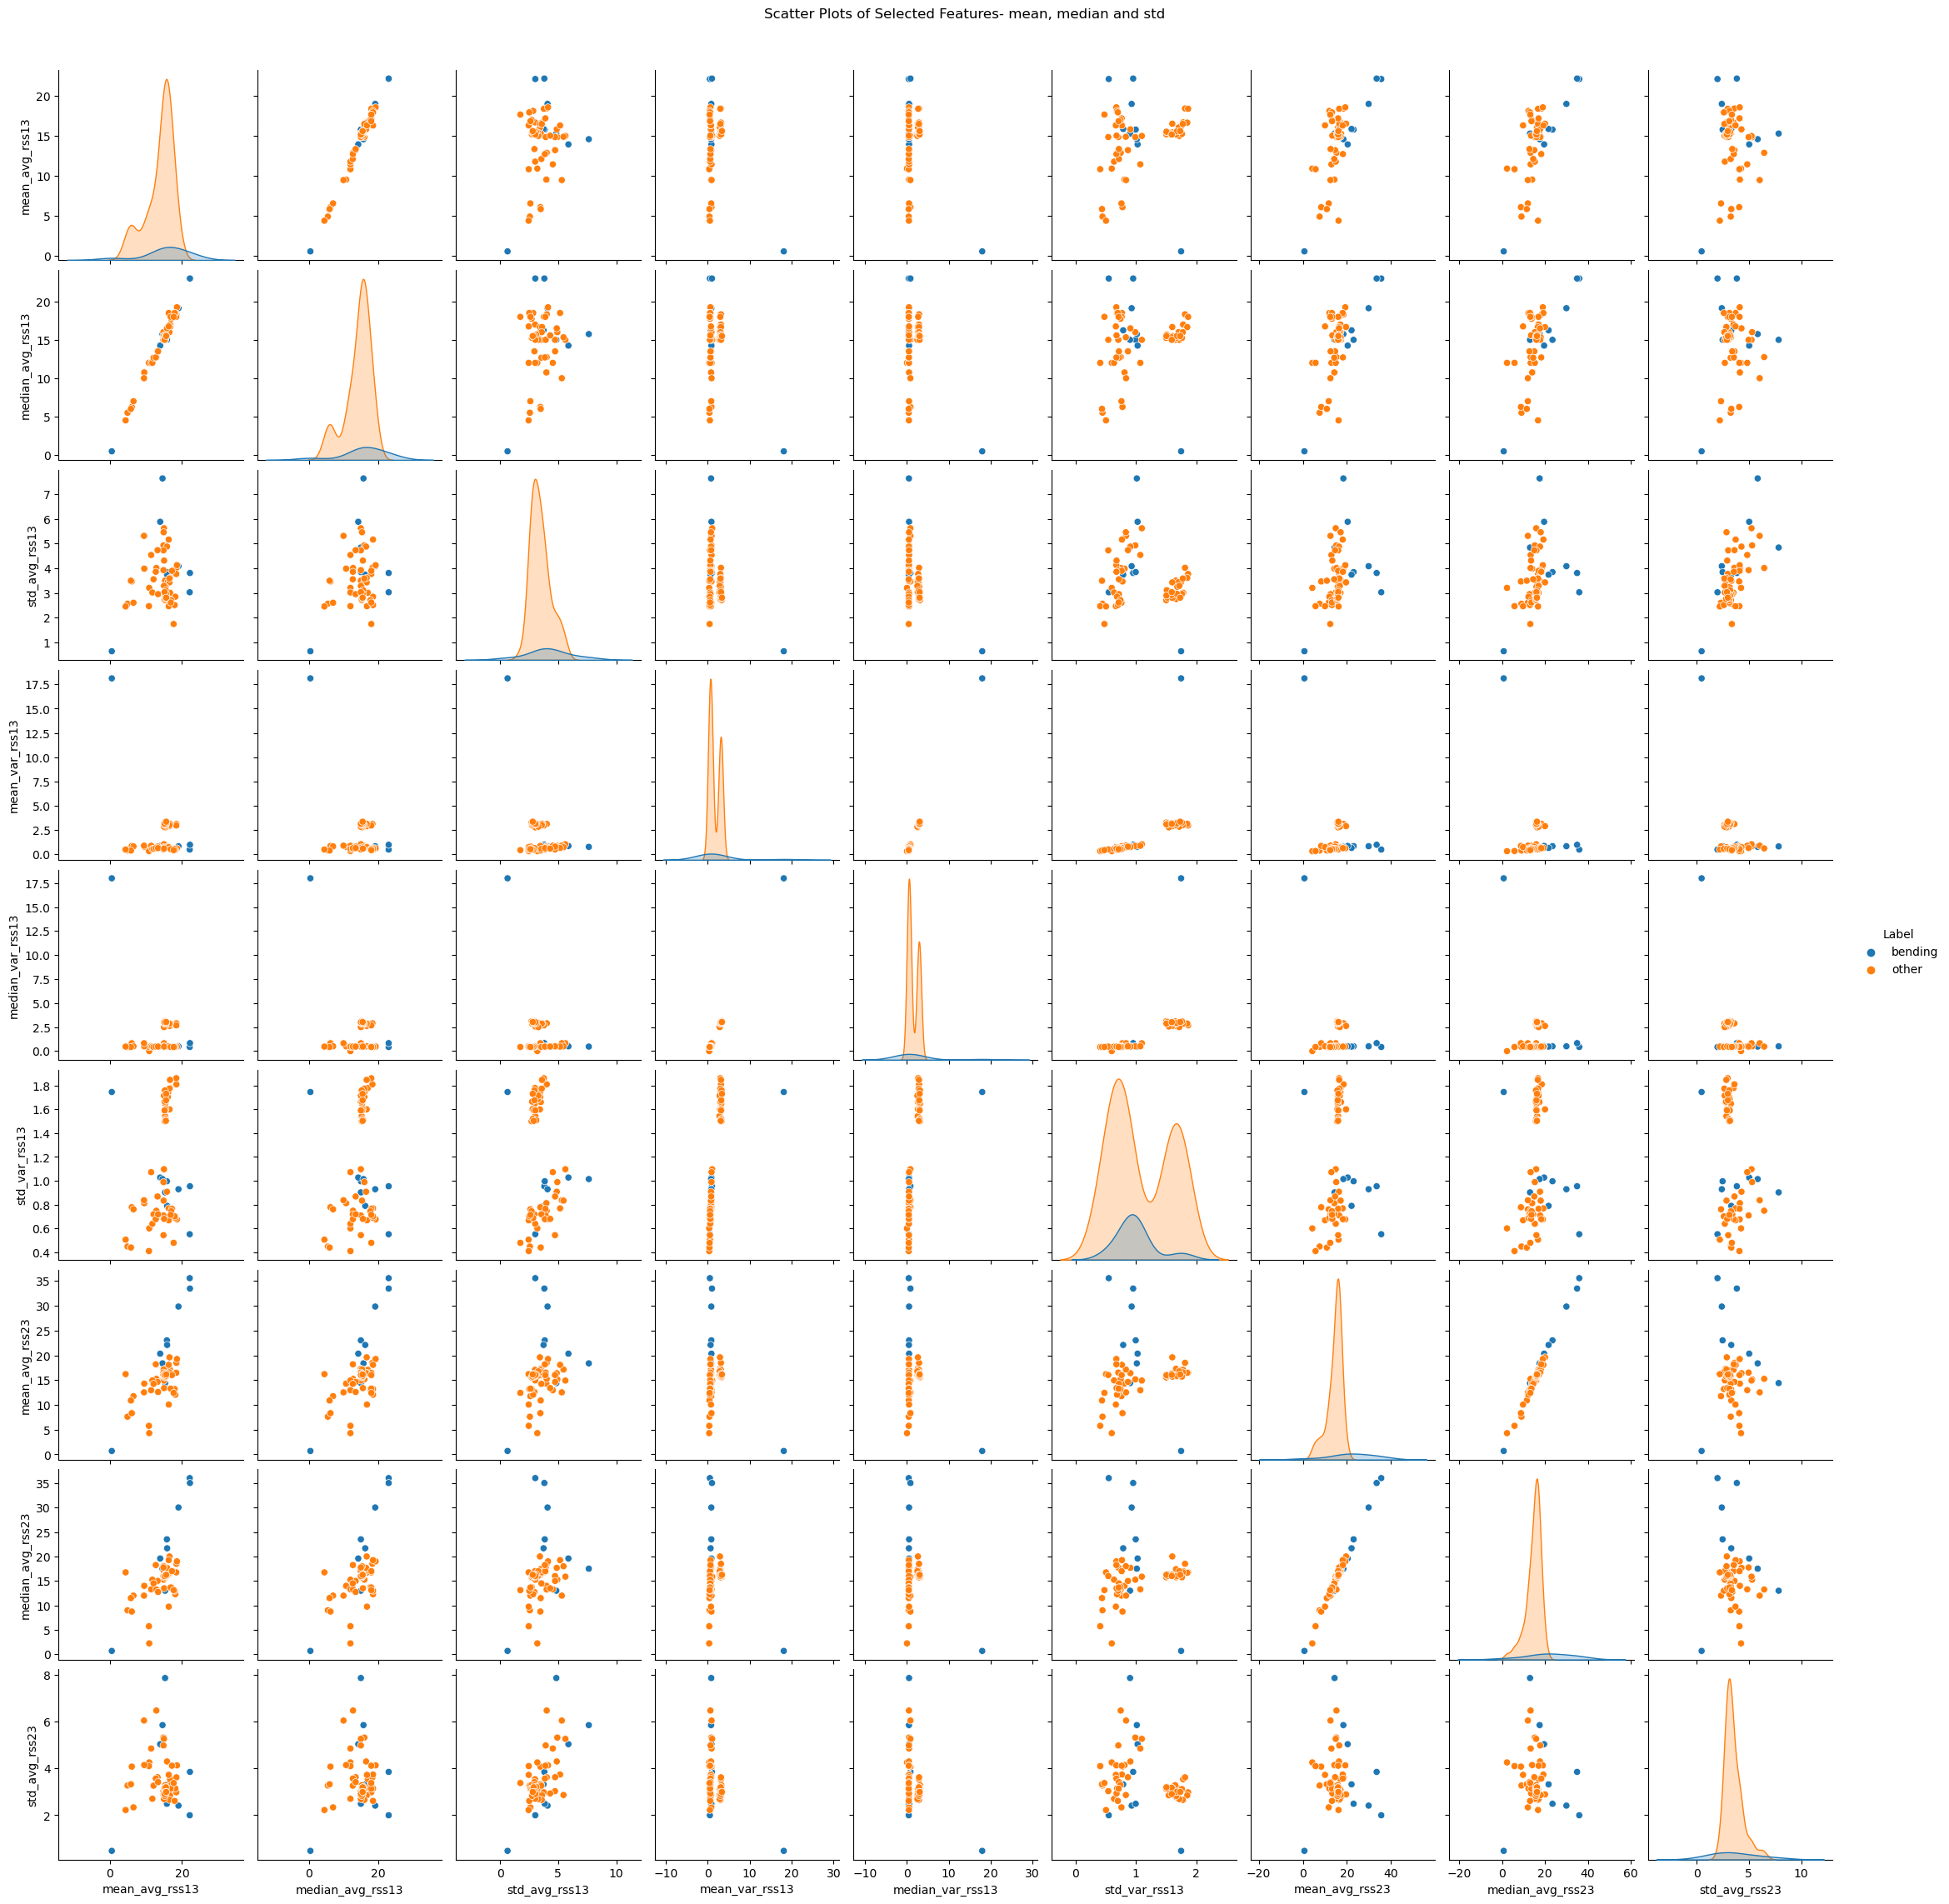

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


series_names = ['avg_rss13', 'var_rss13', 'avg_rss23']  # Corresponding to time series 1, 2, 6
features_formatname = ['mean', 'median', 'std']
col_class = [f"{feature}_{series}" for series in series_names for feature in features_formatname]
col_class.append("Activity")
filtered_df = train_features_df[col_class].copy()

filtered_df['Label'] = filtered_df['Activity'].apply(lambda x: 'bending' if 'bending' in x else 'other')#refered to chatgpt for lambda

sns.pairplot(filtered_df, hue='Label', vars=col_class[:-1])  # Exclude 'Activity' from vars
plt.suptitle('Scatter Plots of Selected Features- mean, median and std', y=1.02)
plt.show()
